In [73]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tkinter import _flatten

In [3]:
import re
import jieba

In [4]:
import gensim
from gensim import corpora, models
import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity
 
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LdaModel

In [219]:
df1 = pd.read_csv('顶流医生.txt', sep='\t',header=None)
df2 = pd.read_csv('优质医生.txt', sep='\t',header=None)
df3 = pd.read_csv('普通医生.txt', sep='\t',header=None)
df4 = pd.read_csv('尾部医生.txt', sep='\t',header=None)
df = pd.concat([df1, df2, df3, df4], ignore_index=True)

In [184]:
def sw(filename):
    with open(filename, encoding="utf-8") as file:
        x = file.readlines()
    y = [word.strip() for word in x]
    return y

In [295]:
name_list = ['stopword/baidu_stopwords.txt', 'stopword/cn_stopwords.txt', 
            'stopword/hit_stopwords.txt','stopword/scu_stopwords.txt','stopword/select.txt']
stop_word = []
for x in name_list:
    stop_word.extend(sw(x))
    stop_word = list(set(stop_word))

In [296]:
df["分词"]=""
for i in range(len(df)):
    line = ''.join(re.findall('[\u4e00-\u9fa5a-zA-Z]',str(df[0][i])))
    if line:
        c = jieba.lcut(line)
        result = [word for word in c if word not in stop_word]
        c = [word for word in result if len(word)>1]
        if c == []:
            df["分词"][i] = None
        else:
            df["分词"][i] = c

In [297]:
df = df.dropna()

In [298]:
df.head()

,0,分词
0,问：是否参与过好大夫等在线诊疗平台或者是您所在医院建立的互联网医院的诊断工作？,"[参与, 过好, 大夫, 或者, 所在, 建立, 诊断]"
1,答：都参加过。,[参加]
2,因为疫情期间，我觉得上级也是有要求的。确实，也是时代和趋势的发展，同时我想我们自己医生也认识...,"[疫情, 期间, 上级, 要求, 确实, 时代, 趋势, 发展, 同时, 自己, 认识, 媒..."
3,问：现阶段医生参与互联网问诊的积极性怎么样，主要是什么吸引医生参加互联网医院问诊？,"[现阶段, 参与, 问诊, 积极性, 怎么样, 主要, 什么, 吸引, 参加, 问诊]"
4,答：有这个意识的医生积极性都很高。首先是我觉得我实实在在我能帮助那些需要我的提供帮助的人，对...,"[答有, 意识, 积极性, 首先, 实实在在, 我能, 帮助, 那些, 需要, 提供, 帮助..."


In [299]:
data_set = df['分词'].tolist()
dictionary = corpora.Dictionary(data_set)  # 构建词典
corpus = [dictionary.doc2bow(text) for text in data_set]  #表示为第几个单词出现了几次

In [112]:
num_topics = 4
ldamodel = LdaModel(corpus, num_topics=num_topics, id2word = dictionary, passes=30,random_state = 1)   #分为10个主题
print(ldamodel.print_topics(num_topics=num_topics, num_words=5))  #每个主题输出15个单词

[(0, '0.029*"管理" + 0.020*"很多" + 0.020*"问题" + 0.020*"医院" + 0.015*"一定"'), (1, '0.042*"医院" + 0.026*"需要" + 0.026*"帮助" + 0.018*"提供" + 0.018*"互联网"'), (2, '0.043*"医生" + 0.038*"医院" + 0.029*"学科" + 0.024*"发展" + 0.020*"互联网"'), (3, '0.030*"互联网" + 0.030*"问诊" + 0.030*"参加" + 0.030*"医生" + 0.017*"参与"')]


In [287]:
#计算coherence
def coherence(num_topics):
    ldamodel = LdaModel(corpus, num_topics=num_topics, id2word = dictionary, passes=50, random_state = 1)
    # print(ldamodel.print_topics(num_topics=num_topics, num_words=5))
    ldacm = CoherenceModel(model=ldamodel, texts=data_set, dictionary=dictionary, coherence='c_v')
    print(ldacm.get_coherence())
    return ldacm.get_coherence()

0.22886453134313914
0.271920130866302
0.28038028318640734
0.36385375950111776
0.37266508902180157
0.35921787194840493
0.35859762249258403


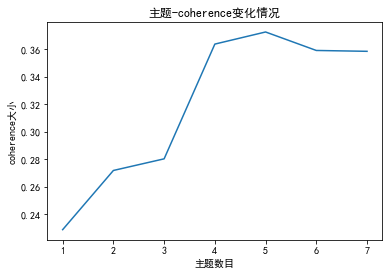

In [300]:
x = range(1,8)
y = [coherence(i) for i in x]
plt.plot(x, y)
plt.xlabel('主题数目')
plt.ylabel('coherence大小')
plt.rcParams['font.sans-serif']=['SimHei']
matplotlib.rcParams['axes.unicode_minus']=False
plt.title('主题-coherence变化情况')
plt.show()

In [302]:
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=4, passes = 50,random_state=1)

for topic in lda.print_topics(num_words = 5):
    termNumber = topic[0]
    print(topic[0], ':', sep='')
    listOfTerms = topic[1].split('+')
    for term in listOfTerms:
        listItems = term.split('*')
        print('  ', listItems[1], '(', listItems[0], ')', sep='')

0:
  "效率" (0.018)
  "时间" ( 0.015)
  "今天" ( 0.015)
  "情况" ( 0.011)
  "沟通"( 0.011)
1:
  "提高" (0.014)
  "个人" ( 0.012)
  "建立" ( 0.009)
  "能够" ( 0.009)
  "薪酬"( 0.007)
2:
  "预约" (0.013)
  "解决" ( 0.012)
  "资源" ( 0.011)
  "需要" ( 0.010)
  "其实"( 0.009)
3:
  "学科" (0.021)
  "影响" ( 0.015)
  "风险" ( 0.014)
  "发展" ( 0.013)
  "慢性病"( 0.011)


In [122]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

In [303]:
pyLDAvis.enable_notebook()

'''
lda: 计算好的话题模型

corpus: 文档词频矩阵

dictionary: 词语空间
'''
d = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.save_html(d, '医生.html')